ANÁLISE COMPARATIVA DO PROBLEMA DA DIETA
Programação Linear - Minimização de Custos com Restrições Nutricionais

Processando instância: data/A1.csv

 RESULTADOS DETALHADOS:
Alimento  Quantidade_100g  Custo_Unitario  Custo_Total
   arroz             0.50             1.0         0.50
  feijao            25.93             1.8        46.67
  frango             0.50             7.0         3.50
   leite             0.30             3.5         1.05
    maçã             0.30             2.5         0.75

 CUSTO TOTAL DA DIETA: R$ 52.47
 TEMPO DE EXECUÇÃO: 0.1008 segundos

 NUTRIENTES ALCANÇADOS vs REQUISITOS:
  ✅ Proteina: 222.27 / 70 (mínimo) [317.5%]
  ✅ Carboidrato: 538.23 / 250 (mínimo) [215.3%]
  ✅ Vitamina: 40.00 / 40 (mínimo) [100.0%]

Processando instância: data/A2.csv

 RESULTADOS DETALHADOS:
Alimento  Quantidade_100g  Custo_Unitario  Custo_Total
   arroz             0.50             1.0         0.50
  feijao            25.56             1.8        46.01
  frango             0.50   

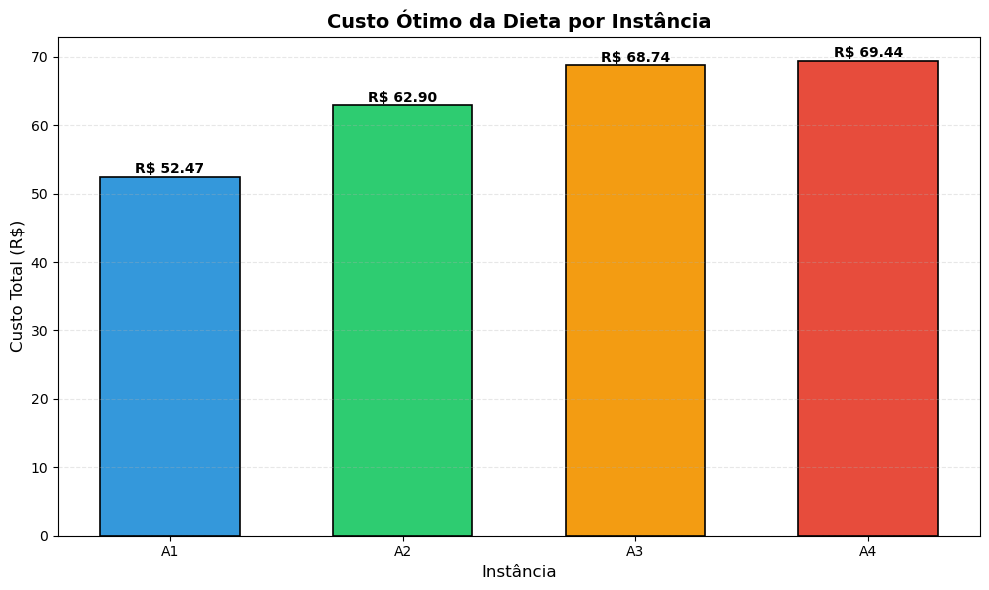

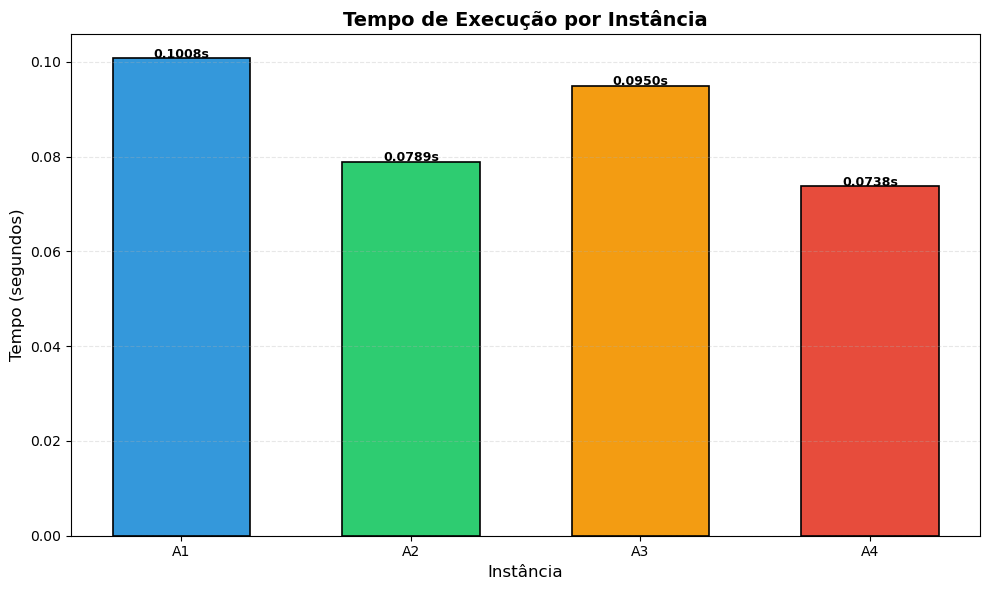

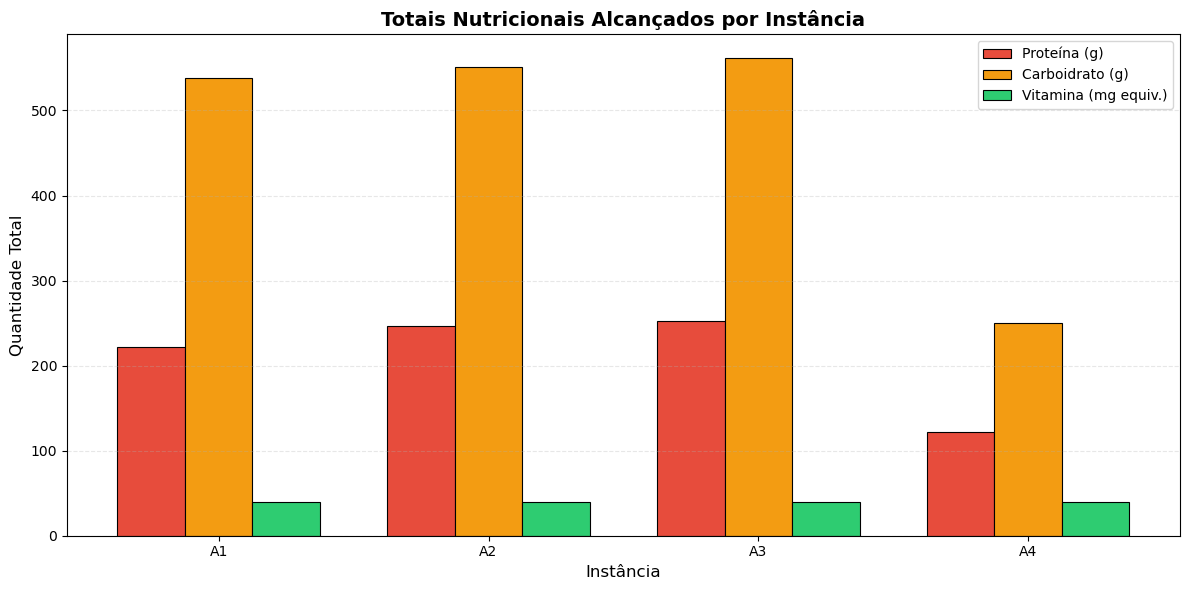

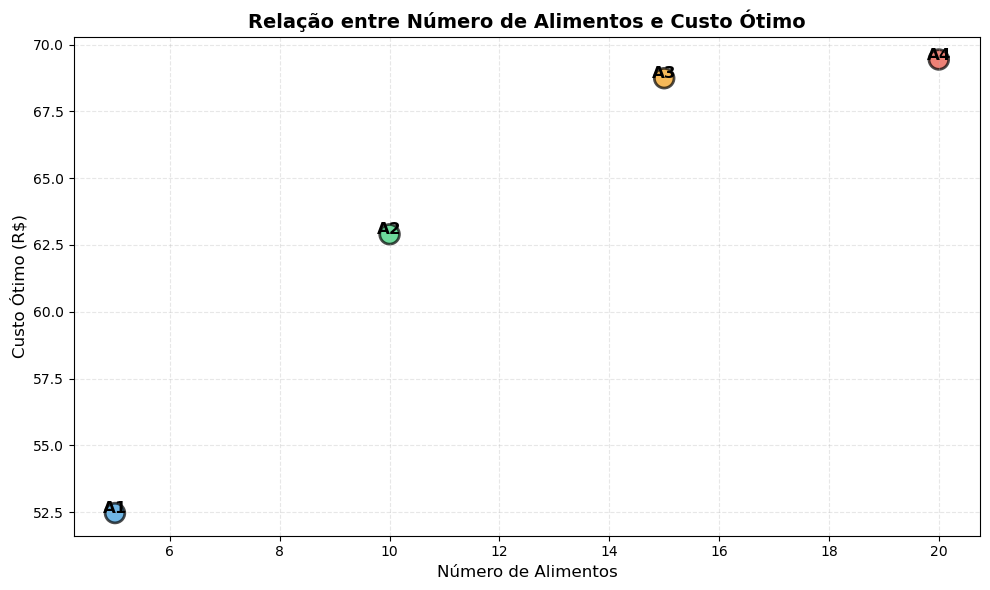


 Análise completa finalizada!


In [11]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, NonNegativeReals, minimize, value
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

def carregar_instancia_dieta(csv_file):

    df = pd.read_csv(csv_file)

    alimentos = df['Alimento'].tolist()
    custos = dict(zip(df['Alimento'], df['Custo_por_100g']))
    limites_minimos = dict(zip(df['Alimento'], df['Minimo_porcao']))

    valores_nutricionais = {}
    for _, row in df.iterrows():
        valores_nutricionais[row['Alimento']] = {
            'proteina': row['Proteina'],
            'carboidrato': row['Carboidrato'],
            'vitamina': row['Vitamina']
        }

    return alimentos, custos, valores_nutricionais, limites_minimos

def resolver_dieta(alimentos, custos, valores_nutricionais, limites_minimos, requisitos):

    model = ConcreteModel()

    model.x = Var(
        alimentos,
        within=NonNegativeReals,
        bounds=lambda m, f: (limites_minimos[f], None)
    )

    model.obj = Objective(
        expr=sum(custos[f] * model.x[f] for f in alimentos),
        sense=minimize
    )

    nutrientes = ['proteina', 'carboidrato', 'vitamina']

    def nutrient_constraints(model, nutriente):
        return sum(valores_nutricionais[f][nutriente] * model.x[f] for f in alimentos) >= requisitos[nutriente]

    model.nutrient_constraints = Constraint(nutrientes, rule=nutrient_constraints)

    solver = SolverFactory('glpk')
    start_time = time.time()
    resultado = solver.solve(model)
    elapsed_time = time.time() - start_time

    if resultado.solver.status != 'ok':
        print(f"Aviso: Solver retornou status {resultado.solver.status}")
    if resultado.solver.termination_condition != 'optimal':
        print(f"Aviso: Solução não é ótima. Condição: {resultado.solver.termination_condition}")


    resultados_alimentos = pd.DataFrame({
        'Alimento': alimentos,
        'Quantidade_100g': [round(value(model.x[f]), 2) for f in alimentos],
        'Custo_Unitario': [custos[f] for f in alimentos],
        'Custo_Total': [round(custos[f] * value(model.x[f]), 2) for f in alimentos]
    })

    totais_nutricionais = {}
    for n in nutrientes:
        total_n = sum(valores_nutricionais[f][n] * value(model.x[f]) for f in alimentos)
        totais_nutricionais[n] = round(total_n, 2)

    custo_otimo = sum(custos[f] * value(model.x[f]) for f in alimentos)

    return resultados_alimentos, custo_otimo, totais_nutricionais, elapsed_time

requisitos = {
    'proteina': 70,
    'carboidrato': 250,
    'vitamina': 40
}

instancias = ['data/A1.csv', 'data/A2.csv', 'data/A3.csv', 'data/A4.csv']

comparativo_geral = []
comparativo_nutricional = []
todos_resultados = {}

print("="*80)
print("ANÁLISE COMPARATIVA DO PROBLEMA DA DIETA")
print("Programação Linear - Minimização de Custos com Restrições Nutricionais")
print("="*80)

for csv_file in instancias:
    print(f"\n{'='*80}")
    print(f"Processando instância: {csv_file}")
    print(f"{'='*80}")

    alimentos, custos, valores_nutricionais, limites_minimos = carregar_instancia_dieta(csv_file)

    resultados_alimentos, custo_otimo, totais_nutricionais, tempo = resolver_dieta(
        alimentos, custos, valores_nutricionais, limites_minimos, requisitos
    )

    todos_resultados[csv_file] = resultados_alimentos

    print(f"\n RESULTADOS DETALHADOS:")
    print(resultados_alimentos.to_string(index=False))

    print(f"\n CUSTO TOTAL DA DIETA: R$ {custo_otimo:.2f}")
    print(f" TEMPO DE EXECUÇÃO: {tempo:.4f} segundos")

    print(f"\n NUTRIENTES ALCANÇADOS vs REQUISITOS:")
    for nutriente, total in totais_nutricionais.items():
        req = requisitos[nutriente]
        percentual = (total / req) * 100
        status = "✅" if total >= req else "❌"
        print(f"  {status} {nutriente.capitalize()}: {total:.2f} / {req} (mínimo) [{percentual:.1f}%]")

    comparativo_geral.append({
        'Instancia': csv_file.split('/')[-1],
        'Num_Alimentos': len(alimentos),
        'Custo_Otimo_RS': round(custo_otimo, 2),
        'Tempo_segundos': round(tempo, 4)
    })

    comparativo_nutricional.append({
        'Instancia': csv_file.split('/')[-1],
        'Proteina_Total': totais_nutricionais['proteina'],
        'Carboidrato_Total': totais_nutricionais['carboidrato'],
        'Vitamina_Total': totais_nutricionais['vitamina'],
        'Custo_RS': round(custo_otimo, 2)
    })


df_comparativo_geral = pd.DataFrame(comparativo_geral)
df_comparativo_nutricional = pd.DataFrame(comparativo_nutricional)


print("\n" + "="*80)
print(" ANÁLISE COMPARATIVA ENTRE INSTÂNCIAS")
print("="*80)

print("\n COMPARATIVO GERAL:")
print(df_comparativo_geral.to_string(index=False))

print("\n COMPARATIVO NUTRICIONAL:")
print(df_comparativo_nutricional.to_string(index=False))

print("\n" + "="*80)
print(" ANÁLISES ESTATÍSTICAS")
print("="*80)

print(f"\n💰 CUSTOS:")
print(f"  • Média: R$ {df_comparativo_geral['Custo_Otimo_RS'].mean():.2f}")
print(f"  • Desvio Padrão: R$ {df_comparativo_geral['Custo_Otimo_RS'].std():.2f}")
print(f"  • Mínimo: R$ {df_comparativo_geral['Custo_Otimo_RS'].min():.2f} ({df_comparativo_geral.loc[df_comparativo_geral['Custo_Otimo_RS'].idxmin(), 'Instancia']})")
print(f"  • Máximo: R$ {df_comparativo_geral['Custo_Otimo_RS'].max():.2f} ({df_comparativo_geral.loc[df_comparativo_geral['Custo_Otimo_RS'].idxmax(), 'Instancia']})")

print(f"\n⏱️  TEMPOS DE EXECUÇÃO:")
print(f"  • Média: {df_comparativo_geral['Tempo_segundos'].mean():.4f}s")
print(f"  • Mínimo: {df_comparativo_geral['Tempo_segundos'].min():.4f}s")
print(f"  • Máximo: {df_comparativo_geral['Tempo_segundos'].max():.4f}s")

print("\n" + "="*80)
print(" GERANDO VISUALIZAÇÕES")
print("="*80)

instancias_labels = [f'A{i}' for i in range(1, 5)]
cores = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

plt.figure(figsize=(10, 6))
plt.bar(instancias_labels, df_comparativo_geral['Custo_Otimo_RS'], color=cores, width=0.6, edgecolor='black', linewidth=1.2)
plt.title('Custo Ótimo da Dieta por Instância', fontsize=14, fontweight='bold')
plt.xlabel('Instância', fontsize=12)
plt.ylabel('Custo Total (R$)', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(df_comparativo_geral['Custo_Otimo_RS']):
    plt.text(i, v + 0.5, f'R$ {v:.2f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(instancias_labels, df_comparativo_geral['Tempo_segundos'], color=cores, width=0.6, edgecolor='black', linewidth=1.2)
plt.title('Tempo de Execução por Instância', fontsize=14, fontweight='bold')
plt.xlabel('Instância', fontsize=12)
plt.ylabel('Tempo (segundos)', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(df_comparativo_geral['Tempo_segundos']):
    plt.text(i, v + 0.0001, f'{v:.4f}s', ha='center', fontweight='bold', fontsize=9)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
nutrientes = ['Proteina_Total', 'Carboidrato_Total', 'Vitamina_Total']
nutrientes_labels = ['Proteína (g)', 'Carboidrato (g)', 'Vitamina (mg equiv.)']
cores_nutrientes = ['#e74c3c', '#f39c12', '#2ecc71']

x = np.arange(len(instancias_labels))
width = 0.25

for i, (nutriente, label, cor) in enumerate(zip(nutrientes, nutrientes_labels, cores_nutrientes)):
    valores = df_comparativo_nutricional[nutriente]
    ax.bar(x + i*width, valores, width, label=label, color=cor, edgecolor='black', linewidth=0.8)

ax.set_xlabel('Instância', fontsize=12)
ax.set_ylabel('Quantidade Total', fontsize=12)
ax.set_title('Totais Nutricionais Alcançados por Instância', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(instancias_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_comparativo_geral['Num_Alimentos'], df_comparativo_geral['Custo_Otimo_RS'],
            s=200, c=cores, edgecolors='black', linewidth=2, alpha=0.7)
for i, txt in enumerate(instancias_labels):
    plt.annotate(txt, (df_comparativo_geral['Num_Alimentos'][i], df_comparativo_geral['Custo_Otimo_RS'][i]),
                 fontsize=12, fontweight='bold', ha='center')
plt.title('Relação entre Número de Alimentos e Custo Ótimo', fontsize=14, fontweight='bold')
plt.xlabel('Número de Alimentos', fontsize=12)
plt.ylabel('Custo Ótimo (R$)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n Análise completa finalizada!")